<a href="https://colab.research.google.com/github/ucfilho/AI/blob/main/AI_2023/CV_CNN/class_002_CNN_blood_cells_may_10_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
tf.__version__

'2.12.0'

In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, BatchNormalization
from tensorflow.keras.layers import  Dropout,ZeroPadding2D, MaxPooling2D, Activation, add
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

import cv2
import numpy as np

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

import zipfile
import pandas as pd


from sklearn.metrics import classification_report, confusion_matrix

In [3]:
IMAGE_SIZE = [224,224]
ImgSize = IMAGE_SIZE[0]
epochs = 16
batch_size = 128

In [4]:
!gdown 1CU4UkqJae07u1tKfp2rajWwwZA0SKiIm

Downloading...
From: https://drive.google.com/uc?id=1CU4UkqJae07u1tKfp2rajWwwZA0SKiIm
To: /content/blood_cell_images.zip
100% 110M/110M [00:01<00:00, 75.7MB/s]


In [5]:
FILE='blood_cell_images.zip'

In [6]:
archive = zipfile.ZipFile(FILE, 'r')
archive.extractall()

In [7]:
!ls

blood_cell_images  blood_cell_images.zip  __MACOSX  sample_data


In [8]:
train_path = 'blood_cell_images/TRAIN'
test_path = 'blood_cell_images/TEST'
images_test = glob(test_path + '/*/*.jp*g')
images_train = glob(train_path + '/*/*.jp*g')

In [9]:
folders_train = glob(train_path + '/*')
folders_test = glob(test_path + '/*')

In [10]:
folders_train

['blood_cell_images/TRAIN/MONOCYTE',
 'blood_cell_images/TRAIN/EOSINOPHIL',
 'blood_cell_images/TRAIN/LYMPHOCYTE',
 'blood_cell_images/TRAIN/NEUTROPHIL']

In [11]:
folders_test

['blood_cell_images/TEST/MONOCYTE',
 'blood_cell_images/TEST/EOSINOPHIL',
 'blood_cell_images/TEST/LYMPHOCYTE',
 'blood_cell_images/TEST/NEUTROPHIL']

In [12]:
ntrain, ntest = len(images_train),len(images_test)
ntrain,ntest

(9957, 2487)

In [13]:
images_train[:4]
num_classes = 4

In [14]:
types = ['NEUTROPHIL', 'EOSINOPHIL', 'MONOCYTE', 'LYMPHOCYTE']

In [15]:

def load_images(images,types=types):

  nsize = len(images)
  X =[]
  y =[]
  names =[]
  k = 0

  for i in range(nsize): 
    img = image.load_img(images[i])
    im = cv2.resize(np.array(img), (224, 224))
    im = preprocess_input(im)
    k += 1
    if( k % 3 == 0):
      X.append(im)

      if(types[0] in images[i]):
        names.append(types[0])
        y.append(0)
      elif(types[1] in images[i]):
        names.append(types[1])
        y.append(1)
      elif(types[2] in images[i]):
        names.append(types[2])
        y.append(2)
      else:
        names.append(types[3])
        y.append(3)

  X =np.array(X)
  return X,y,names

In [16]:

X_train, y_train, names_train = load_images(images_train)
X_test, y_test, names_test = load_images(images_test)

In [17]:
X_train[0].shape

(224, 224, 3)

In [18]:
df = pd.DataFrame({'name':names_train,'class':y_train})
y_train = pd.get_dummies(df['class'])
y_train

,0,1,2,3
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0
...,...,...,...,...
3314,1,0,0,0
3315,1,0,0,0
3316,1,0,0,0
3317,1,0,0,0


In [19]:
for i in range(4): 
  df_plot= df[(df["class"] == i)]
  n= df_plot.shape[0]
  print(types[i],n)

NEUTROPHIL 833
EOSINOPHIL 832
MONOCYTE 826
LYMPHOCYTE 828


In [20]:
df = pd.DataFrame({'name':names_test,'class':y_test})
y_test = pd.get_dummies(df['class'])
y_test

,0,1,2,3
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0
...,...,...,...,...
824,1,0,0,0
825,1,0,0,0
826,1,0,0,0
827,1,0,0,0


In [21]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [22]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model.layers))

Number of layers in the base model:  18


In [23]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [24]:
r = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    verbose=2
)

Epoch 1/30
104/104 - 37s - loss: 1.4078 - accuracy: 0.2639 - val_loss: 1.3834 - val_accuracy: 0.2606 - 37s/epoch - 360ms/step
Epoch 2/30
104/104 - 18s - loss: 1.3791 - accuracy: 0.2962 - val_loss: 1.3684 - val_accuracy: 0.2533 - 18s/epoch - 170ms/step
Epoch 3/30
104/104 - 18s - loss: 1.3583 - accuracy: 0.3227 - val_loss: 1.3407 - val_accuracy: 0.3884 - 18s/epoch - 170ms/step
Epoch 4/30
104/104 - 18s - loss: 1.3288 - accuracy: 0.3498 - val_loss: 1.3102 - val_accuracy: 0.4077 - 18s/epoch - 174ms/step
Epoch 5/30
104/104 - 18s - loss: 1.2895 - accuracy: 0.3929 - val_loss: 1.2791 - val_accuracy: 0.4138 - 18s/epoch - 171ms/step
Epoch 6/30
104/104 - 18s - loss: 1.2588 - accuracy: 0.4269 - val_loss: 1.2494 - val_accuracy: 0.4258 - 18s/epoch - 175ms/step
Epoch 7/30
104/104 - 18s - loss: 1.2372 - accuracy: 0.4387 - val_loss: 1.2304 - val_accuracy: 0.4403 - 18s/epoch - 169ms/step
Epoch 8/30
104/104 - 17s - loss: 1.2069 - accuracy: 0.4456 - val_loss: 1.2079 - val_accuracy: 0.4427 - 17s/epoch - 168

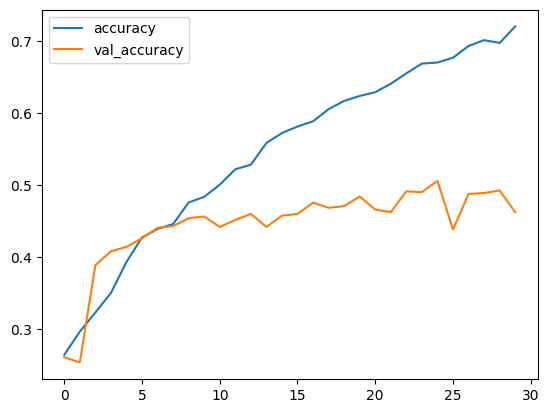

In [25]:
plt.plot(r.history['accuracy'],label='accuracy')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()

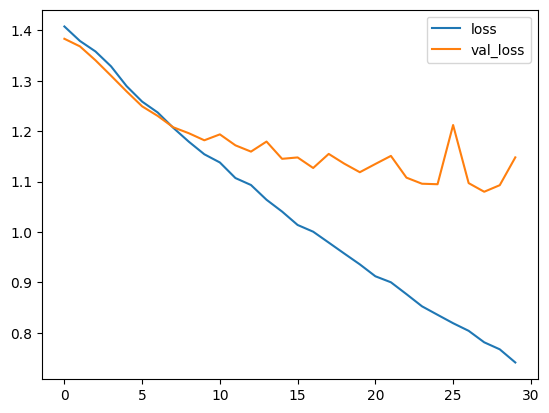

In [26]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()